In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

def f():
    pd.set_option('display.max_rows', None)

def nf():
    pd.set_option('display.max_rows', 4)

    
import warnings
warnings.filterwarnings('ignore')

def dp(df, r = 5, c = None):
    from IPython.display import display
    with pd.option_context('display.max_rows', 4, 'display.max_columns', None):
        display(df)

def fg(w = 6, h = 4, dpi = 120):
    plt.rcParams['figure.figsize'] = (w,h)
    plt.rcParams['figure.dpi'] = dpi
fg()

# Carregar dados

In [2]:
data = pd.read_csv('data/data.csv', sep = ';')

In [3]:
data.dtypes

id          int64
periodo     int64
dummy      object
comprou     int64
dtype: object

In [4]:
dummy = pd.get_dummies(data)

In [5]:
dummy

,id,periodo,comprou,dummy_a,dummy_b,dummy_c
0,804591,1,1,1,0,0
1,262974,1,0,0,1,0
...,...,...,...,...,...,...
87,291785,4,1,0,1,0
88,357959,1,1,0,0,1


In [6]:
from sklearn.model_selection import train_test_split

# Primeiro a separação de periodo

In [7]:
in_ = dummy[dummy['periodo']<4]

In [8]:
out_ = dummy[dummy['periodo']>3]

In [9]:
Xin = in_.drop('comprou', axis = 1)

In [10]:
yin = in_['comprou']

### Treinamento com o primeiro período


In [11]:
X_train, X_test, y_train, y_test = train_test_split(Xin, yin, test_size = 0.3)

### Chamar modelo

In [19]:
from xgboost import XGBClassifier

xgboost = XGBClassifier()

In [20]:
class ml():
    
    '''classe para pipeline de ml'''
    def __init__(self, X_train, X_test, y_train, y_test, model, modelname, threshold = 0.5):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.modelname = modelname
        self.threshold = threshold
        
        self.fit()
        
    def fit(self):
        self.model.fit(self.X_train, self.y_train)
        
    def probs(self, new_X_test = None):
        
        self.new_X_test = new_X_test
        
        '''Predict proba'''
        if new_X_test is None:
            return self.model.predict_proba(self.X_test)[:,1]
        else:
            return self.model.predict_proba(self.new_X_test)[:,1]
        
    def pred(self):
        import numpy as np
        return np.where(self.probs() > self.threshold, 1, 0)

    def matriz(self):
        from confusionmatrix import matriz_confusao as cm
        cm = cm(self.y_test, self.pred())
        return cm

    def roccurve(self):
        '''Curva roc'''
        from sklearn.metrics import roc_curve
        import matplotlib.pyplot as plt
        # Gerar os dados da diagonal (no skill classifier)
        
        ns_probs = [0 for item in range(len(self.y_test))]
        ns_fpr, ns_tpr, ns_thres = roc_curve(self.y_test, ns_probs)

        #Probabilidades da classe positiva
        fpr, tpr, thresholds = roc_curve(self.y_test, self.probs())
        
        plt.plot(fpr, tpr, marker = '.', label = self.modelname)
        plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Classificador base')
        plt.xlabel('Razão de Falsos Positivos')
        plt.ylabel('Razão de Verdadeiros Positivos')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def precisionrecall(self):
        '''Precision Recall Curve'''
        import matplotlib.pyplot as plt
        from sklearn.metrics import precision_recall_curve

        precision, recall, thresholds = precision_recall_curve(self.y_test, self.probs())
        no_skill = len(self.y_test[self.y_test ==1]) / len(self.y_test)

        plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'Classificador base')
        plt.plot(precision, recall, marker = '.', label =  self.modelname)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
#     def f1():
#         return 
    
    def auc(self):
        import numpy as np
        '''AUC'''
        from sklearn.metrics import roc_auc_score
        return np.round(roc_auc_score(self.y_test, self.probs()),2)
    
    def gini(self):
        '''GINI'''
        return 2*self.auc() - 1

    def cvresults(self, cv = 10):
        '''Metricas gerais: 
        - acuracia
        - f1
        - recall
        - precision'''
        from sklearn.model_selection import cross_validate
        res = cross_validate(self.model, self.X, self.y, cv = cv, 
                                  scoring = ['accuracy','f1','recall','precision'],
                                  return_train_score = True)

        f1 = res['test_f1'].mean()
        precision = res['test_precision'].mean()
        recall = res['test_recall'].mean()
        acuracia = res['test_accuracy'].mean()

        cvresults = pd.DataFrame({'acuracia':[acuracia],
                                  'precisao':[precision],
                                  'recall':[recall],
                                  'f1':[f1]})

        return cvresults

In [21]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(35, 5)

(16, 5)

(35,)

(16,)

In [22]:
ml = ml(X_train, X_test, y_train, y_test, xgboost, 'XGBoost')

[01:49:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
y_predin = ml.probs()

In [24]:
y_predin

array([0.37925225, 0.09388923, 0.8190579 , 0.13640043, 0.6244271 ,
       0.8190579 , 0.81165344, 0.1824737 , 0.15204535, 0.7933908 ,
       0.13371535, 0.98006094, 0.14124501, 0.9445196 , 0.5565253 ,
       0.17285292], dtype=float32)

### Fazer previsão com o outro período

In [25]:
out_

,id,periodo,comprou,dummy_a,dummy_b,dummy_c
20,382573,4,1,1,0,0
21,365640,4,1,0,0,1
22,102210,4,0,0,1,0
23,558569,4,0,0,0,1
24,722053,4,0,1,0,0
25,843593,4,1,0,0,1
26,245427,5,1,0,1,0
27,198013,5,1,0,0,1
28,527606,5,0,0,0,1
29,207841,5,1,0,1,0


In [26]:
Xout = out_.drop('comprou', axis = 1)

yout = out_['comprou']

In [27]:
y_predout = ml.probs(new_X_test = Xout)

In [28]:
y_predout

array([0.80845207, 0.29191652, 0.22822404, 0.38400888, 0.1082512 ,
       0.29492956, 0.22822404, 0.13371535, 0.1034946 , 0.22822404,
       0.13371535, 0.96879387, 0.22822404, 0.13371535, 0.6244271 ,
       0.78860426, 0.13068014, 0.27274206, 0.6244271 , 0.78860426,
       0.2200272 , 0.7646453 , 0.0101664 , 0.07820669, 0.83973974,
       0.49995255, 0.49995255, 0.6244271 , 0.22822404, 0.29191652,
       0.08929633, 0.07820669, 0.2200272 , 0.38400888, 0.12951334,
       0.78073466, 0.78860426, 0.22822404], dtype=float32)

# Agora como plotar os dois? 

### Join X_test e y_predin

In [29]:
X_test

,id,periodo,dummy_a,dummy_b,dummy_c
75,298006,2,1,0,0
56,738092,1,1,0,0
46,494732,2,0,0,1
1,262974,1,0,1,0
15,152401,3,1,0,0
5,510731,2,0,0,1
10,812358,2,0,0,1
70,218287,2,0,1,0
3,214772,1,0,0,1
59,857923,1,0,1,0


In [30]:
y_test

75    1
56    0
46    0
1     0
15    1
5     0
10    0
70    1
3     1
59    0
54    1
42    1
66    0
41    1
79    0
44    0
Name: comprou, dtype: int64

In [31]:
predin = pd.concat([X_test.reset_index(),y_test.reset_index(),pd.DataFrame(y_predin, columns = ['prob'])], axis = 1)

In [32]:
predin

,index,id,periodo,dummy_a,dummy_b,dummy_c,index,comprou,prob
0,75,298006,2,1,0,0,75,1,0.379252
1,56,738092,1,1,0,0,56,0,0.093889
2,46,494732,2,0,0,1,46,0,0.819058
3,1,262974,1,0,1,0,1,0,0.136400
4,15,152401,3,1,0,0,15,1,0.624427
5,5,510731,2,0,0,1,5,0,0.819058
6,10,812358,2,0,0,1,10,0,0.811653
7,70,218287,2,0,1,0,70,1,0.182474
8,3,214772,1,0,0,1,3,1,0.152045
9,59,857923,1,0,1,0,59,0,0.793391


In [33]:
predout = pd.concat([Xout.reset_index(),yout.reset_index(),pd.DataFrame(y_predout, columns = ['prob'])], axis = 1)

In [34]:
Xout.shape
yout.shape
y_predout.shape

(38, 5)

(38,)

(38,)

In [35]:
predout

,index,id,periodo,dummy_a,dummy_b,dummy_c,index,comprou,prob
0,20,382573,4,1,0,0,20,1,0.808452
1,21,365640,4,0,0,1,21,1,0.291917
2,22,102210,4,0,1,0,22,0,0.228224
3,23,558569,4,0,0,1,23,0,0.384009
4,24,722053,4,1,0,0,24,0,0.108251
5,25,843593,4,0,0,1,25,1,0.294930
6,26,245427,5,0,1,0,26,1,0.228224
7,27,198013,5,0,0,1,27,1,0.133715
8,28,527606,5,0,0,1,28,0,0.103495
9,29,207841,5,0,1,0,29,1,0.228224


In [36]:
stack = pd.concat([predin,predout], axis = 0)

In [37]:
stack.shape

(54, 9)

In [38]:
stack

,index,id,periodo,dummy_a,dummy_b,dummy_c,index,comprou,prob
0,75,298006,2,1,0,0,75,1,0.379252
1,56,738092,1,1,0,0,56,0,0.093889
2,46,494732,2,0,0,1,46,0,0.819058
3,1,262974,1,0,1,0,1,0,0.136400
4,15,152401,3,1,0,0,15,1,0.624427
5,5,510731,2,0,0,1,5,0,0.819058
6,10,812358,2,0,0,1,10,0,0.811653
7,70,218287,2,0,1,0,70,1,0.182474
8,3,214772,1,0,0,1,3,1,0.152045
9,59,857923,1,0,1,0,59,0,0.793391


In [39]:
import plotnine as pn 
from plotnine import *

# Agrupar clusters de compradores

In [40]:
problist = [x for x in np.arange(0.0,1.0,0.1)]

In [41]:
problist

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [42]:
conds = [
         (stack['prob'] > 0.0) & (stack['prob'] < 0.1),
         (stack['prob'] > 0.1) & (stack['prob'] < 0.2),
         (stack['prob'] > 0.2) & (stack['prob'] < 0.3),
         (stack['prob'] > 0.3) & (stack['prob'] < 0.4),
         (stack['prob'] > 0.4) & (stack['prob'] < 0.5),
         (stack['prob'] > 0.5) & (stack['prob'] < 0.6),
         (stack['prob'] > 0.6) & (stack['prob'] < 0.7),
         (stack['prob'] > 0.7) & (stack['prob'] < 0.8),
         (stack['prob'] > 0.8) & (stack['prob'] < 0.9),
         (stack['prob'] > 0.9) & (stack['prob'] < 1.0)
         ]

In [43]:
choices = ['C'+str(i) for i in range(0,10)]

In [44]:
choices

['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

In [45]:
stack['cluster'] = np.select(conds, choices)

# Plots

In [52]:
f()
stack
nf()

,index,id,periodo,dummy_a,dummy_b,dummy_c,index,comprou,prob,cluster
0,75,298006,2,1,0,0,75,1,0.379252,C3
1,56,738092,1,1,0,0,56,0,0.093889,C0
2,46,494732,2,0,0,1,46,0,0.819058,C8
3,1,262974,1,0,1,0,1,0,0.136400,C1
4,15,152401,3,1,0,0,15,1,0.624427,C6
5,5,510731,2,0,0,1,5,0,0.819058,C8
6,10,812358,2,0,0,1,10,0,0.811653,C8
7,70,218287,2,0,1,0,70,1,0.182474,C1
8,3,214772,1,0,0,1,3,1,0.152045,C1
9,59,857923,1,0,1,0,59,0,0.793391,C7


### groupby mais expandido para depois fazer um groupby menos expandido para ter a porcentagem

In [53]:
f()
stack.groupby(['cluster','periodo']).agg({'id':'count'}).reset_index()
nf()

,cluster,periodo,id
0,C0,1,1
1,C0,4,1
2,C0,5,1
3,C0,6,2
4,C1,1,2
5,C1,2,3
6,C1,3,1
7,C1,4,2
8,C1,5,4
9,C1,6,1


In [54]:
expand = stack.groupby(['cluster','periodo'])['id'].sum().rename('count')

In [55]:
expand

cluster  periodo
C0       1           738092
         4           721415
                     ...   
C9       2          1491875
         5           446302
Name: count, Length: 30, dtype: int64

In [56]:
expand / expand.groupby(level = 0).sum()

cluster  periodo
C0       1          0.263476
         4          0.257523
                      ...   
C9       2          0.769731
         5          0.230269
Name: count, Length: 30, dtype: float64

In [70]:
plot = pd.DataFrame(expand/expand.groupby('periodo').sum()).reset_index().rename(columns = {'count':'vol'})

In [71]:
from plotnine import *

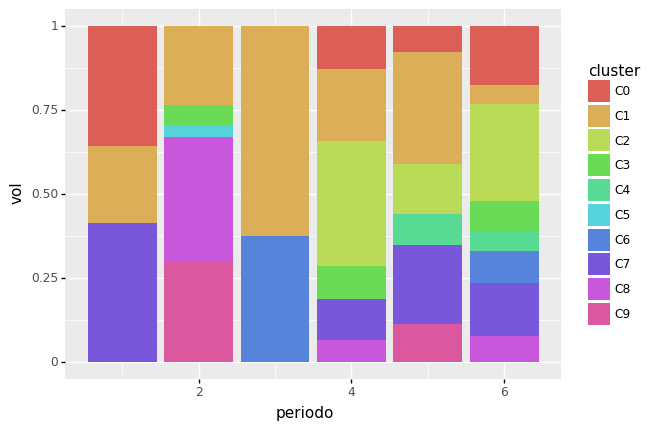

<ggplot: (176076356569)>

In [72]:
(
    ggplot(plot, aes(x = 'periodo', y ='vol')) + 
    geom_col(aes(fill = 'cluster'))
)

# Para Score médio

In [76]:
scat = stack.groupby(['cluster','periodo']).agg({'prob':'mean'}).reset_index()

In [82]:
f()
scat
nf()

,cluster,periodo,prob
0,C0,1,0.093889
1,C0,4,0.089296
2,C0,5,0.078207
3,C0,6,0.044187
4,C1,1,0.144223
5,C1,2,0.165524
6,C1,3,0.133715
7,C1,4,0.118882
8,C1,5,0.126160
9,C1,6,0.130680


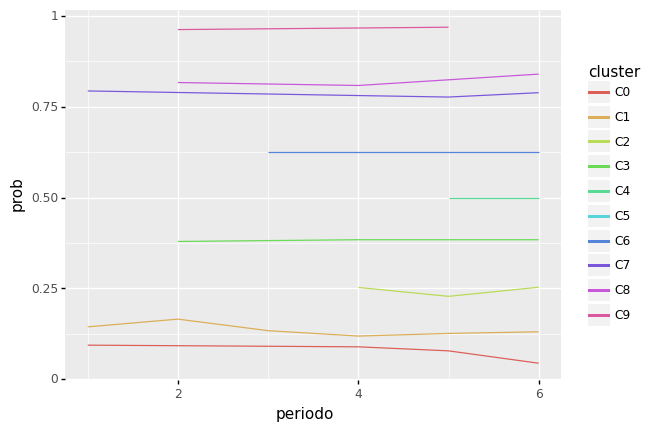

<ggplot: (176077702187)>

In [83]:
(
    ggplot(scat, aes(x = 'periodo', y ='prob')) + 
#     geom_point(aes(color = 'cluster')) + 
    geom_line(aes(color = 'cluster'))
)